In [1]:
import numpy as np
import seaborn as sns
import torch

import umap
import matplotlib.pyplot as plt
import pandas as pd
from community import community_louvain
from torch_geometric.utils import k_hop_subgraph,to_networkx,from_networkx
import matplotlib

import utils
import plots
from model_AE import reduction_AE
from model_GAT import Encoder,SenGAE,train_GAT
from model_Sencell import Sencell
from sampling import sub_sampling_by_random
from model_Sencell import cell_optim,update_cell_embeddings
from sampling import identify_sengene_then_sencell

import logging
import os,time
import argparse

from linetimer import CodeTimer

is_jupyter=True

parser = argparse.ArgumentParser(description='Main program for sencells')

parser.add_argument('--output_dir', type=str, default='./outputs', help='')
parser.add_argument('--exp_name', type=str, default='', help='')
parser.add_argument('--sencell_num', type=int, default=75, help='')
parser.add_argument('--retrain', action='store_true', default=False, help='')

if is_jupyter:
    args = parser.parse_args(args=[])
    args.exp_name='s5'
    args.retrain=False  
else:
    args = parser.parse_args()
args.is_jupyter=is_jupyter


if not os.path.exists(args.output_dir):
    os.makedirs(args.output_dir)

logging.basicConfig(format='%(asctime)s.%(msecs)03d [%(levelname)s] [%(filename)s:%(lineno)d] %(message)s',
                    datefmt='# %Y-%m-%d %H:%M:%S')

logging.getLogger().setLevel(logging.INFO)
logger = logging.getLogger()

# Part 1: load and process data
# cell_cluster_arr在画umap的时候用
if 's5' in args.exp_name:
    adata,cluster_cell_ls,cell_cluster_arr,celltype_names=utils.load_data()
elif 'healthy' in args.exp_name:
    adata,cluster_cell_ls,cell_cluster_arr,celltype_names=utils.load_data_healthy()
elif 'disease' in args.exp_name:
    adata,cluster_cell_ls,cell_cluster_arr,celltype_names=utils.load_data_disease()

# plots.umapPlot(adata.obsm['X_umap'],clusters=cell_cluster_arr,labels=celltype_names)

new_data,markers_index,\
sen_gene_ls,nonsen_gene_ls,gene_names=utils.process_data(adata,cluster_cell_ls,cell_cluster_arr)

gene_cell=new_data.X.toarray().T
args.gene_num=gene_cell.shape[0]
args.cell_num=gene_cell.shape[1]

print(f'cell num: {new_data.shape[0]}, gene num: {new_data.shape[1]}')

graph_nx=utils.build_graph_nx(gene_cell,cell_cluster_arr,sen_gene_ls,nonsen_gene_ls,gene_names)
logger.info("Part 1, data loading and processing end!")

# Part 2: generate init embedding
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device:',device)
args.device=device

if args.retrain:
    gene_embed,cell_embed=reduction_AE(gene_cell,device)
    print(gene_embed.shape,cell_embed.shape)
    torch.save(gene_embed,os.path.join(args.output_dir,f'{args.exp_name}_gene.emb'))
    torch.save(cell_embed,os.path.join(args.output_dir,f'{args.exp_name}_cell.emb'))
else:
    gene_embed=torch.load(os.path.join(args.output_dir,f'{args.exp_name}_gene.emb'))
    cell_embed=torch.load(os.path.join(args.output_dir,f'{args.exp_name}_cell.emb'))

graph_nx=utils.add_nx_embedding(graph_nx,gene_embed,cell_embed)
graph_pyg=utils.build_graph_pyg(gene_cell,gene_embed,cell_embed)
logger.info("Part 2, AE end!")

# Part 3: train GAT
# graph_pyg=graph_pyg.to('cpu')

GAT_model=train_GAT(graph_nx,graph_pyg,args,retrain=args.retrain,resampling=args.retrain)
logger.info("Part 3, training GAT end!")


all_gene_ls=[]

list_sencell_cover=[]
list_sengene_cover=[]

cellmodel=Sencell().to(device)
optimizer = torch.optim.Adam(cellmodel.parameters(), lr=0.001, 
                                weight_decay=1e-3)

all_marker_index=sen_gene_ls
    
iteration_results=[]
for iteration in range(5):
    logger.info(f"iteration: {iteration}")
    t0=time.time()
    sampled_graph,sencell_dict,nonsencell_dict,cell_clusters,big_graph_index_dict=sub_sampling_by_random(graph_nx,
                                                            sen_gene_ls,
                                                            nonsen_gene_ls,
                                                            GAT_model,
                                                            args,
                                                            all_marker_index,
                                                            n_gene=len(all_marker_index),                                                        
                                                            gene_rate=0.3,cell_rate=0.5,
                                                            debug=False)
    old_sengene_indexs=all_marker_index
    print(time.time()-t0)
    for epoch in range(10):
        logger.info(f"epoch: {epoch}")
        old_sencell_dict=sencell_dict
        with CodeTimer("cell_optim",unit="s"):
            cellmodel,sencell_dict,nonsencell_dict=cell_optim(cellmodel,optimizer,
                                                          sencell_dict,nonsencell_dict,args,
                                                         train=True)
        
        with CodeTimer("update_cell_embeddings",unit="s"):
            sampled_graph=update_cell_embeddings(sampled_graph,sencell_dict,nonsencell_dict)
        with CodeTimer("identify_sengene_then_sencell",unit="s"):
            sencell_dict,nonsencell_dict, \
            sen_gene_indexs,nonsen_gene_indexs=identify_sengene_then_sencell(sampled_graph,GAT_model,
                                                                          sencell_dict,nonsencell_dict,
                                                                          cell_clusters,
                                                                          big_graph_index_dict,
                                                                          len(all_marker_index),args)

        ratio_cell=utils.get_sencell_cover(old_sencell_dict,sencell_dict)
        ratio_gene=utils.get_sengene_cover(old_sengene_indexs,sen_gene_indexs)
        old_sengene_indexs=sen_gene_indexs
        break
        if ratio_cell==1 and ratio_gene==1:
            print("Get convergence!")
            break
    break
    iteration_results.append([sen_gene_indexs,sencell_dict])

# outputs_path=os.path.join(args.output_dir,f'{args.exp_name}_outputs.data')
# print("Experiments saved!",outputs_path)
# torch.save([sencell_dict,sen_gene_indexs],outputs_path)


cluster 数量： 21
celltype names: ['Macrophages', 'T cell lineage', 'Unknown', 'B cell lineage', 'Innate lymphoid cell NK', 'AT2', 'Monocytes', 'Multiciliated lineage', 'Dendritic cells', 'EC capillary', 'Mast cells', 'Fibroblasts', 'Secretory', 'EC venous', 'Lymphatic EC mature', 'AT1', 'Basal', 'EC arterial', 'Myofibroblasts', 'None', 'Submucosal Secretory']
-----------------------  ----
Macrophages              6941
T cell lineage            749
Unknown                   618
B cell lineage            374
Innate lymphoid cell NK   327
AT2                       294
Monocytes                 228
Multiciliated lineage     194
Dendritic cells           177
EC capillary              138
Mast cells                100
Fibroblasts                93
Secretory                  86
EC venous                  74
Lymphatic EC mature        68
AT1                        27
Basal                      26
EC arterial                20
Myofibroblasts             17
None                        6
Submucosal

# 2022-12-05 21:05:55.480 [INFO] [4186770663.py:75] Part 1, data loading and processing end!


device: cuda:0
the number of edges: 963522
edge index:  torch.Size([2, 963522])
node feature:  torch.Size([12844, 128])
Pyg graph: Data(x=[12844, 128], edge_index=[2, 1927044], y=[12844])


# 2022-12-05 21:05:58.717 [INFO] [4186770663.py:93] Part 2, AE end!
# 2022-12-05 21:05:58.729 [INFO] [4186770663.py:99] Part 3, training GAT end!
# 2022-12-05 21:05:58.732 [INFO] [4186770663.py:115] iteration: 0


graph.is_directed(): False
Start sampling subgraph randomly ...
    Sengene num: 351, Nonsengen num: 1935
subgraph total node num: (12844,)
After sampling, gene num:  tensor(2286)


# 2022-12-05 21:14:22.255 [INFO] [4186770663.py:129] epoch: 0


obj saved ./outputs/s5_cell_score_dict_test
    Sencell num: 75, Nonsencell num: 750
503.5218291282654
这一簇没有非老化细胞： 20
55.061866760253906
这一簇没有非老化细胞： 20
54.69025421142578
这一簇没有非老化细胞： 20
54.14696502685547
这一簇没有非老化细胞： 20
53.31749725341797
这一簇没有非老化细胞： 20
52.058929443359375
这一簇没有非老化细胞： 20
50.196083068847656
这一簇没有非老化细胞： 20
47.51750564575195
这一簇没有非老化细胞： 20
43.76995086669922
这一簇没有非老化细胞： 20
40.466304779052734
这一簇没有非老化细胞： 20
39.80908966064453
这一簇没有非老化细胞： 20
40.85962677001953
这一簇没有非老化细胞： 20
41.97028350830078
这一簇没有非老化细胞： 20
42.31507110595703
这一簇没有非老化细胞： 20
41.68907165527344
这一簇没有非老化细胞： 20
40.489017486572266
这一簇没有非老化细胞： 20
39.22026824951172
这一簇没有非老化细胞： 20
38.191139221191406
这一簇没有非老化细胞： 20
37.60277557373047
这一簇没有非老化细胞： 20
37.47844314575195
这一簇没有非老化细胞： 20
37.523094177246094
Code block 'cell_optim' took: 44.70209 s
Code block 'update_cell_embeddings' took: 0.01855 s
rechoice sengene num: 351 rechoice nonsengene num: 1935
obj saved ./outputs/s5_cell_score_dict_test
    Sencell num: 75, Nonsencell num: 

In [2]:
cellmodel=Sencell().to(device)
optimizer = torch.optim.Adam(cellmodel.parameters(), lr=0.001, 
                                weight_decay=1e-3)


all_marker_index=sen_gene_ls
    
iteration_results=[]
for iteration in range(5):
    logger.info(f"iteration: {iteration}")
    sampled_graph,sencell_dict,nonsencell_dict,cell_clusters,big_graph_index_dict=sub_sampling_by_random(graph_nx,
                                                            sen_gene_ls,
                                                            nonsen_gene_ls,
                                                            GAT_model,
                                                            args,
                                                            all_marker_index,
                                                            n_gene=len(all_marker_index),                                                        
                                                            gene_rate=0.3,cell_rate=0.5,
                                                            debug=False)
    old_sengene_indexs=all_marker_index
    for epoch in range(10):
        logger.info(f"epoch: {epoch}")
        old_sencell_dict=sencell_dict
        cellmodel,sencell_dict,nonsencell_dict=cell_optim(cellmodel,optimizer,
                                                          sencell_dict,nonsencell_dict,args,
                                                         train=True)
        sampled_graph=update_cell_embeddings(sampled_graph,sencell_dict,nonsencell_dict)
        sencell_dict,nonsencell_dict, \
        sen_gene_indexs,nonsen_gene_indexs=identify_sengene_then_sencell(sampled_graph,GAT_model,
                                                                      sencell_dict,nonsencell_dict,
                                                                      cell_clusters,
                                                                      big_graph_index_dict,
                                                                      len(all_marker_index),args)

        get_sencell_cover(old_sencell_dict,sencell_dict)
        get_sengene_cover(old_sengene_indexs,sen_gene_indexs)
        old_sengene_indexs=sen_gene_indexs
    iteration_results.append([sen_gene_indexs,sencell_dict])

# 2022-11-30 16:12:01.945 [INFO] [3419743573.py:10] iteration: 0


Start sampling subgraph randomly ...
    Sengene num: 351, Nonsengen num: 351
subgraph total node num: (11260,)
After sampling, gene num:  tensor(702)


# 2022-11-30 16:13:34.303 [INFO] [3419743573.py:22] epoch: 0


obj saved ./outputs/s5_cell_score_dict
    Sencell num: 200, Nonsencell num: 2000
这一簇没有非老化细胞： 20
68.61312866210938
这一簇没有非老化细胞： 20
64.5830078125
这一簇没有非老化细胞： 20
58.44092559814453
这一簇没有非老化细胞： 20
49.10270690917969
这一簇没有非老化细胞： 20
42.21515655517578
这一簇没有非老化细胞： 20
46.74324417114258
这一簇没有非老化细胞： 20
49.19110107421875
这一簇没有非老化细胞： 20
45.66767883300781
这一簇没有非老化细胞： 20
41.64388656616211
这一簇没有非老化细胞： 20
39.66569519042969
这一簇没有非老化细胞： 20
39.767051696777344
这一簇没有非老化细胞： 20
39.40530776977539
这一簇没有非老化细胞： 20
38.028404235839844
这一簇没有非老化细胞： 20
36.03836441040039
这一簇没有非老化细胞： 20
34.59233856201172
这一簇没有非老化细胞： 20
34.61294937133789
这一簇没有非老化细胞： 20
35.83994674682617
这一簇没有非老化细胞： 20
36.4024658203125
这一簇没有非老化细胞： 20
35.79627990722656
这一簇没有非老化细胞： 20
34.56907653808594
rechoice sengene num: 351 rechoice nonsengene num: 351


# 2022-11-30 16:17:21.652 [INFO] [3419743573.py:22] epoch: 1


obj saved ./outputs/s5_cell_score_dict
    Sencell num: 200, Nonsencell num: 2000
sencell cover: 0.72
sengene cover: 0.7207977207977208
45.1309814453125
45.47966384887695
45.62794876098633
45.61005783081055
45.44075012207031
45.12397766113281
44.65562438964844
44.02197265625
43.2030029296875
42.165950775146484
40.870670318603516
39.27824783325195
37.34517288208008
35.06385803222656
32.547691345214844
30.011404037475586
28.708698272705078
28.71839714050293
29.834260940551758
31.151426315307617
rechoice sengene num: 351 rechoice nonsengene num: 351


# 2022-11-30 16:20:27.110 [INFO] [3419743573.py:22] epoch: 2


obj saved ./outputs/s5_cell_score_dict
    Sencell num: 200, Nonsencell num: 2000
sencell cover: 0.9
sengene cover: 0.9145299145299145
28.1458797454834
27.975820541381836
27.333494186401367
26.460243225097656
25.61810874938965
25.022335052490234
24.7191104888916
24.625171661376953
24.624860763549805
24.631000518798828
24.591733932495117
24.50635528564453
24.404254913330078
24.328344345092773
24.311250686645508
24.32308006286621
24.312959671020508
24.245454788208008
24.11795425415039
23.954885482788086
rechoice sengene num: 351 rechoice nonsengene num: 351


# 2022-11-30 16:23:22.619 [INFO] [3419743573.py:22] epoch: 3


obj saved ./outputs/s5_cell_score_dict
    Sencell num: 200, Nonsencell num: 2000
sencell cover: 0.94
sengene cover: 0.9430199430199431
23.953588485717773
23.813270568847656
23.658832550048828
23.49498176574707
23.328397750854492
23.162681579589844
23.00090980529785
22.850719451904297
22.716930389404297
22.598848342895508
22.488277435302734
22.38080596923828
22.269512176513672
22.1483097076416
22.01115608215332
21.853321075439453
21.672773361206055
21.471508026123047
21.252565383911133
21.022573471069336
rechoice sengene num: 351 rechoice nonsengene num: 351


# 2022-11-30 16:26:18.381 [INFO] [3419743573.py:22] epoch: 4


obj saved ./outputs/s5_cell_score_dict
    Sencell num: 200, Nonsencell num: 2000
sencell cover: 0.99
sengene cover: 0.9743589743589743
20.79435157775879
20.573711395263672
20.369752883911133
20.18101692199707
20.00874137878418
19.853681564331055
19.72516441345215
19.622133255004883
19.538862228393555
19.475309371948242
19.43307113647461
19.41845703125
19.429086685180664
19.46050453186035
19.500797271728516
19.529809951782227
19.538362503051758
19.527345657348633
19.501710891723633
19.466217041015625
rechoice sengene num: 351 rechoice nonsengene num: 351


# 2022-11-30 16:29:13.867 [INFO] [3419743573.py:22] epoch: 5


obj saved ./outputs/s5_cell_score_dict
    Sencell num: 200, Nonsencell num: 2000
sencell cover: 0.995
sengene cover: 0.9943019943019943
19.47933006286621
19.429950714111328
19.381752014160156
19.33678436279297
19.297122955322266
19.264184951782227
19.237747192382812
19.21762466430664
19.203712463378906
19.194067001342773
19.18546485900879
19.176612854003906
19.167449951171875
19.157638549804688
19.146953582763672
19.13501739501953
19.121633529663086
19.106760025024414
19.090621948242188
19.07360076904297
rechoice sengene num: 351 rechoice nonsengene num: 351


# 2022-11-30 16:32:09.619 [INFO] [3419743573.py:22] epoch: 6


obj saved ./outputs/s5_cell_score_dict
    Sencell num: 200, Nonsencell num: 2000
sencell cover: 1.0
sengene cover: 1.0
19.057830810546875
19.039033889770508
19.02032470703125
19.001657485961914
18.983308792114258
18.965717315673828
18.949108123779297
18.933679580688477
18.919092178344727
18.905059814453125
18.891239166259766
18.877490997314453
18.864116668701172
18.85082244873047
18.8377628326416
18.824325561523438
18.810588836669922
18.796470642089844
18.78211212158203
18.767711639404297
rechoice sengene num: 351 rechoice nonsengene num: 351


# 2022-11-30 16:35:03.938 [INFO] [3419743573.py:22] epoch: 7


obj saved ./outputs/s5_cell_score_dict
    Sencell num: 200, Nonsencell num: 2000
sencell cover: 1.0
sengene cover: 1.0
18.761411666870117
18.74675750732422
18.732160568237305
18.718067169189453
18.704303741455078
18.69087791442871
18.67756462097168
18.66421127319336
18.650951385498047
18.637901306152344
18.62511444091797
18.612192153930664
18.598989486694336
18.585723876953125
18.572620391845703
18.559585571289062
18.546449661254883
18.53312873840332
18.519737243652344
18.50663948059082
rechoice sengene num: 351 rechoice nonsengene num: 351


# 2022-11-30 16:37:58.859 [INFO] [3419743573.py:22] epoch: 8


obj saved ./outputs/s5_cell_score_dict
    Sencell num: 200, Nonsencell num: 2000
sencell cover: 1.0
sengene cover: 1.0
18.49246597290039
18.47962760925293
18.46685028076172
18.454023361206055
18.441198348999023
18.428382873535156
18.41561508178711
18.402860641479492
18.390085220336914
18.37726593017578
18.364404678344727
18.35161018371582
18.33885383605957
18.32607078552246
18.313274383544922
18.300512313842773
18.287750244140625
18.274978637695312
18.262216567993164
18.249460220336914
rechoice sengene num: 351 rechoice nonsengene num: 351


# 2022-11-30 16:40:53.721 [INFO] [3419743573.py:22] epoch: 9


obj saved ./outputs/s5_cell_score_dict
    Sencell num: 200, Nonsencell num: 2000
sencell cover: 1.0
sengene cover: 1.0
18.237913131713867
18.22508430480957
18.21229362487793
18.199581146240234
18.186840057373047
18.173965454101562
18.161109924316406
18.14837646484375
18.135730743408203
18.1230411529541
18.11029815673828
18.09760856628418
18.084959030151367
18.07229232788086
18.059659957885742
18.047077178955078
18.034534454345703
18.021961212158203
18.009336471557617
17.996685028076172
rechoice sengene num: 351 rechoice nonsengene num: 351


# 2022-11-30 16:43:47.916 [INFO] [3419743573.py:10] iteration: 1


obj saved ./outputs/s5_cell_score_dict
    Sencell num: 200, Nonsencell num: 2000
sencell cover: 1.0
sengene cover: 1.0
Start sampling subgraph randomly ...
    Sengene num: 351, Nonsengen num: 351
subgraph total node num: (11260,)
After sampling, gene num:  tensor(702)


# 2022-11-30 16:45:16.370 [INFO] [3419743573.py:22] epoch: 0


obj saved ./outputs/s5_cell_score_dict
    Sencell num: 200, Nonsencell num: 2000
这一簇没有非老化细胞： 20
256.5957336425781
这一簇没有非老化细胞： 20
186.51109313964844
这一簇没有非老化细胞： 20
114.04439544677734
这一簇没有非老化细胞： 20
59.185707092285156
这一簇没有非老化细胞： 20
31.70821762084961
这一簇没有非老化细胞： 20
30.01913833618164
这一簇没有非老化细胞： 20
32.86143112182617
这一簇没有非老化细胞： 20
36.19048309326172
这一簇没有非老化细胞： 20
37.60670471191406
这一簇没有非老化细胞： 20
36.61140823364258
这一簇没有非老化细胞： 20
34.96147918701172
这一簇没有非老化细胞： 20
34.88371276855469
这一簇没有非老化细胞： 20
35.41066360473633
这一簇没有非老化细胞： 20
34.8763542175293
这一簇没有非老化细胞： 20
33.154380798339844
这一簇没有非老化细胞： 20
30.817594528198242
这一簇没有非老化细胞： 20
29.66626739501953
这一簇没有非老化细胞： 20
29.437877655029297
这一簇没有非老化细胞： 20
29.893634796142578
这一簇没有非老化细胞： 20
29.88701057434082
rechoice sengene num: 351 rechoice nonsengene num: 351


# 2022-11-30 16:48:48.727 [INFO] [3419743573.py:22] epoch: 1


obj saved ./outputs/s5_cell_score_dict
    Sencell num: 200, Nonsencell num: 2000
sencell cover: 0.77
sengene cover: 0.7407407407407407
32.273170471191406
31.541967391967773
30.130807876586914
28.05927085876465
25.94689178466797
24.74532127380371
24.840463638305664
26.05828857421875
27.173398971557617
27.453292846679688
26.820146560668945
25.725576400756836
24.721567153930664
24.229902267456055
24.360876083374023
24.758699417114258
25.087753295898438
25.233341217041016
25.171117782592773
24.927501678466797
rechoice sengene num: 351 rechoice nonsengene num: 351


# 2022-11-30 16:51:40.363 [INFO] [3419743573.py:22] epoch: 2


obj saved ./outputs/s5_cell_score_dict
    Sencell num: 200, Nonsencell num: 2000
sencell cover: 0.835
sengene cover: 0.9259259259259259
24.911590576171875
24.499248504638672
24.215526580810547
24.111860275268555
24.151426315307617
24.243392944335938
24.298107147216797
24.252952575683594
24.096559524536133
23.868305206298828
23.625600814819336
23.412681579589844
23.2545223236084
23.150644302368164
23.072967529296875
22.99034309387207
22.88594627380371
22.755373001098633
22.613906860351562
22.49111557006836
rechoice sengene num: 351 rechoice nonsengene num: 351


# 2022-11-30 16:54:31.129 [INFO] [3419743573.py:22] epoch: 3


obj saved ./outputs/s5_cell_score_dict
    Sencell num: 200, Nonsencell num: 2000
sencell cover: 0.975
sengene cover: 0.9515669515669516
22.550609588623047
22.522611618041992
22.524375915527344
22.540082931518555
22.547189712524414
22.524005889892578
22.463394165039062
22.375736236572266
22.27936553955078
22.19207191467285
22.12272834777832
22.070302963256836
22.02788543701172
21.984899520874023
21.9344482421875
21.87383460998535
21.805706024169922
21.734655380249023
21.668615341186523
21.608192443847656
rechoice sengene num: 351 rechoice nonsengene num: 351


# 2022-11-30 16:57:21.990 [INFO] [3419743573.py:22] epoch: 4


obj saved ./outputs/s5_cell_score_dict
    Sencell num: 200, Nonsencell num: 2000
sencell cover: 0.995
sengene cover: 0.9857549857549858
21.802581787109375
21.758310317993164
21.705095291137695
21.641639709472656
21.569942474365234
21.49421501159668
21.418800354003906
21.34636688232422
21.27766990661621
21.210979461669922
21.1440372467041
21.072616577148438
20.99608039855957


# 2022-11-30 17:00:13.233 [INFO] [3419743573.py:22] epoch: 5


obj saved ./outputs/s5_cell_score_dict
    Sencell num: 200, Nonsencell num: 2000
sencell cover: 1.0
sengene cover: 0.9971509971509972
20.43462371826172
20.3228702545166
20.21152687072754
20.101011276245117
18.425128936767578
rechoice sengene num: 351 rechoice nonsengene num: 351


# 2022-11-30 17:03:04.340 [INFO] [3419743573.py:22] epoch: 6


obj saved ./outputs/s5_cell_score_dict
    Sencell num: 200, Nonsencell num: 2000
sencell cover: 0.995
sengene cover: 1.0
18.507976531982422
18.487213134765625
18.475271224975586
18.46869659423828
18.46401596069336
18.458667755126953
18.451210021972656
18.44023323059082
18.4244441986084
18.403593063354492
18.377779006958008
18.347396850585938
18.313364028930664
18.276525497436523
18.238338470458984
18.200111389160156
18.16275405883789
18.12626838684082
18.092208862304688
18.06195068359375
rechoice sengene num: 351 rechoice nonsengene num: 351


# 2022-11-30 17:05:55.661 [INFO] [3419743573.py:22] epoch: 7


obj saved ./outputs/s5_cell_score_dict
    Sencell num: 200, Nonsencell num: 2000
sencell cover: 1.0
sengene cover: 1.0
18.048845291137695
18.024972915649414
18.004396438598633
17.985076904296875
17.96649742126465
17.947872161865234
17.92819595336914
17.907739639282227
17.88668441772461
17.86491584777832
17.842714309692383
17.820255279541016
17.797420501708984
17.774574279785156
17.751317977905273
17.72835350036621
17.705337524414062
17.68271255493164
17.660680770874023
17.639516830444336
rechoice sengene num: 351 rechoice nonsengene num: 351


# 2022-11-30 17:08:46.455 [INFO] [3419743573.py:22] epoch: 8


obj saved ./outputs/s5_cell_score_dict
    Sencell num: 200, Nonsencell num: 2000
sencell cover: 1.0
sengene cover: 1.0
17.618738174438477
17.593509674072266
17.5654239654541
17.54079818725586
17.52107048034668
17.503332138061523
17.485551834106445
17.465251922607422
17.442670822143555
17.41925811767578
17.397626876831055
17.377567291259766
17.357789993286133
17.33740997314453
17.31671142578125
17.296358108520508
17.277067184448242
17.25896453857422
17.24141502380371
17.223587036132812
rechoice sengene num: 351 rechoice nonsengene num: 351


# 2022-11-30 17:11:38.197 [INFO] [3419743573.py:22] epoch: 9


obj saved ./outputs/s5_cell_score_dict
    Sencell num: 200, Nonsencell num: 2000
sencell cover: 1.0
sengene cover: 1.0
17.293128967285156
17.2314510345459
17.167631149291992
17.130937576293945
17.11958122253418
17.118131637573242
17.113739013671875
17.0972900390625
17.067447662353516
17.032014846801758
17.000812530517578
16.979896545410156
16.965534210205078
16.949434280395508
16.929248809814453
16.906274795532227
16.883045196533203
16.861337661743164
16.840490341186523
16.81906509399414
rechoice sengene num: 351 rechoice nonsengene num: 351


# 2022-11-30 17:14:28.716 [INFO] [3419743573.py:10] iteration: 2


obj saved ./outputs/s5_cell_score_dict
    Sencell num: 200, Nonsencell num: 2000
sencell cover: 1.0
sengene cover: 1.0
Start sampling subgraph randomly ...
    Sengene num: 351, Nonsengen num: 351
subgraph total node num: (11260,)
After sampling, gene num:  tensor(702)


# 2022-11-30 17:15:59.650 [INFO] [3419743573.py:22] epoch: 0


obj saved ./outputs/s5_cell_score_dict
    Sencell num: 200, Nonsencell num: 2000
这一簇没有非老化细胞： 20
250.831298828125
这一簇没有非老化细胞： 20
171.48854064941406
这一簇没有非老化细胞： 20
96.7820053100586
这一簇没有非老化细胞： 20
48.49943923950195
这一簇没有非老化细胞： 20
27.737409591674805
这一簇没有非老化细胞： 20
25.09178924560547
这一簇没有非老化细胞： 20
26.324064254760742
这一簇没有非老化细胞： 20
25.969051361083984
这一簇没有非老化细胞： 20
25.000442504882812
这一簇没有非老化细胞： 20
23.491369247436523
这一簇没有非老化细胞： 20
22.03090476989746
这一簇没有非老化细胞： 20
22.0478458404541
这一簇没有非老化细胞： 20
22.69143295288086
这一簇没有非老化细胞： 20
22.66193389892578
这一簇没有非老化细胞： 20
21.903223037719727
这一簇没有非老化细胞： 20
21.570579528808594
这一簇没有非老化细胞： 20
21.80913543701172
这一簇没有非老化细胞： 20
21.995223999023438
这一簇没有非老化细胞： 20
21.63408088684082
这一簇没有非老化细胞： 20
21.378507614135742
rechoice sengene num: 351 rechoice nonsengene num: 351
obj saved ./outputs/s5_cell_score_dict


# 2022-11-30 17:19:25.453 [INFO] [3419743573.py:22] epoch: 1


    Sencell num: 200, Nonsencell num: 2000
sencell cover: 0.78
sengene cover: 0.7578347578347578
28.02754020690918
26.927030563354492
25.356178283691406
24.018798828125
23.426067352294922
23.722339630126953
24.525676727294922
25.118022918701172
25.074308395385742
24.441511154174805
23.581483840942383
22.913665771484375
22.631803512573242
22.65074348449707
22.748336791992188
22.76496124267578
22.61466407775879
22.30132293701172
21.8950138092041
21.490489959716797
rechoice sengene num: 351 rechoice nonsengene num: 351


# 2022-11-30 17:22:26.900 [INFO] [3419743573.py:22] epoch: 2


obj saved ./outputs/s5_cell_score_dict
    Sencell num: 200, Nonsencell num: 2000
sencell cover: 0.895
sengene cover: 0.9344729344729344
22.984556198120117
22.705556869506836
22.580156326293945
22.587419509887695
22.635244369506836
22.654415130615234
22.599695205688477
22.472335815429688
22.30705451965332
22.143783569335938
22.015377044677734
21.929298400878906
21.878520965576172
21.834312438964844
21.77125358581543
21.675439834594727
21.544078826904297
21.384973526000977
21.214149475097656
21.04846954345703
rechoice sengene num: 351 rechoice nonsengene num: 351


# 2022-11-30 17:25:36.576 [INFO] [3419743573.py:22] epoch: 3


obj saved ./outputs/s5_cell_score_dict
    Sencell num: 200, Nonsencell num: 2000
sencell cover: 0.97
sengene cover: 0.9715099715099715
21.001068115234375
20.871131896972656
20.74793815612793
20.624380111694336
20.494043350219727
20.353134155273438
20.19559669494629
20.02280616760254
19.84478187561035
19.664817810058594
19.50136947631836
19.361122131347656
19.223838806152344
19.091909408569336
18.96987533569336
18.864181518554688
18.76545524597168
18.66414451599121
18.561172485351562
18.45893096923828
rechoice sengene num: 351 rechoice nonsengene num: 351


# 2022-11-30 17:28:46.756 [INFO] [3419743573.py:22] epoch: 4


obj saved ./outputs/s5_cell_score_dict
    Sencell num: 200, Nonsencell num: 2000
sencell cover: 0.995
sengene cover: 0.9914529914529915
18.49490737915039
18.401355743408203
18.283241271972656
18.216522216796875
18.19011688232422
18.202293395996094
18.23523712158203
18.264429092407227
18.27043914794922
18.250507354736328
18.21473503112793
18.177766799926758
18.148927688598633
18.128570556640625
18.11063003540039
18.08805274963379
18.05504035949707
18.0126953125
17.96739959716797
17.928030014038086
rechoice sengene num: 351 rechoice nonsengene num: 351
obj saved ./outputs/s5_cell_score_dict


# 2022-11-30 17:31:57.046 [INFO] [3419743573.py:22] epoch: 5


    Sencell num: 200, Nonsencell num: 2000
sencell cover: 1.0
sengene cover: 1.0
17.915557861328125
17.904085159301758
17.88574981689453
17.860408782958984
17.832962036132812
17.813533782958984
17.795738220214844
17.78057098388672
17.768783569335938
17.757740020751953
17.740020751953125
17.71649169921875
17.691795349121094
17.670501708984375
17.65483283996582
17.642663955688477
17.629987716674805
17.614904403686523
17.597185134887695
17.578250885009766
rechoice sengene num: 351 rechoice nonsengene num: 351
obj saved ./outputs/s5_cell_score_dict


# 2022-11-30 17:35:05.542 [INFO] [3419743573.py:22] epoch: 6


    Sencell num: 200, Nonsencell num: 2000
sencell cover: 1.0
sengene cover: 1.0
17.58839988708496
17.56728172302246
17.547100067138672
17.5299015045166
17.51559066772461
17.5030460357666
17.490266799926758
17.475404739379883
17.45854949951172
17.440471649169922
17.423133850097656
17.407970428466797
17.39383316040039
17.379987716674805
17.365795135498047
17.350988388061523
17.33539390563965
17.31934356689453
17.303478240966797
17.288652420043945
rechoice sengene num: 351 rechoice nonsengene num: 351


# 2022-11-30 17:38:15.702 [INFO] [3419743573.py:22] epoch: 7


obj saved ./outputs/s5_cell_score_dict
    Sencell num: 200, Nonsencell num: 2000
sencell cover: 1.0
sengene cover: 1.0
17.286083221435547
17.27009391784668
17.253726959228516
17.23748016357422
17.222064971923828
17.207202911376953
17.192699432373047
17.17819595336914
17.16341209411621
17.1483211517334
17.13325309753418
17.118101119995117
17.103012084960938
17.0882625579834
17.073556900024414
17.058839797973633
17.04413414001465
17.029382705688477
17.01460075378418
16.999980926513672
rechoice sengene num: 351 rechoice nonsengene num: 351


# 2022-11-30 17:41:25.608 [INFO] [3419743573.py:22] epoch: 8


obj saved ./outputs/s5_cell_score_dict
    Sencell num: 200, Nonsencell num: 2000
sencell cover: 1.0
sengene cover: 1.0
16.98431396484375
16.969863891601562
16.955415725708008
16.940784454345703
16.925992965698242
16.911163330078125
16.896495819091797
16.88198471069336
16.867496490478516
16.852956771850586
16.83832550048828
16.823604583740234
16.808870315551758
16.79423713684082
16.77961540222168
16.764955520629883
16.75025749206543
16.735530853271484
16.720783233642578
16.706039428710938
rechoice sengene num: 351 rechoice nonsengene num: 351


# 2022-11-30 17:44:35.248 [INFO] [3419743573.py:22] epoch: 9


obj saved ./outputs/s5_cell_score_dict
    Sencell num: 200, Nonsencell num: 2000
sencell cover: 1.0
sengene cover: 1.0
16.691417694091797
16.67647933959961
16.661741256713867
16.64718246459961
16.632652282714844
16.61810874938965
16.603422164916992
16.588682174682617
16.573999404907227
16.559532165527344
16.544858932495117
16.530241012573242
16.51567268371582
16.500946044921875
16.486278533935547
16.471521377563477
16.45679473876953
16.44198989868164
16.42719841003418
16.41230010986328
rechoice sengene num: 351 rechoice nonsengene num: 351


# 2022-11-30 17:47:45.103 [INFO] [3419743573.py:10] iteration: 3


obj saved ./outputs/s5_cell_score_dict
    Sencell num: 200, Nonsencell num: 2000
sencell cover: 1.0
sengene cover: 1.0
Start sampling subgraph randomly ...
    Sengene num: 351, Nonsengen num: 351
subgraph total node num: (11260,)
After sampling, gene num:  tensor(702)


# 2022-11-30 17:49:14.760 [INFO] [3419743573.py:22] epoch: 0


obj saved ./outputs/s5_cell_score_dict
    Sencell num: 200, Nonsencell num: 2000
这一簇没有非老化细胞： 20
317.44085693359375
这一簇没有非老化细胞： 20
201.3228302001953
这一簇没有非老化细胞： 20
94.99908447265625
这一簇没有非老化细胞： 20
55.70784378051758
这一簇没有非老化细胞： 20
43.5193977355957
这一簇没有非老化细胞： 20
28.822864532470703
这一簇没有非老化细胞： 20
22.606624603271484
这一簇没有非老化细胞： 20
23.671369552612305
这一簇没有非老化细胞： 20
23.021728515625
这一簇没有非老化细胞： 20
22.546850204467773
这一簇没有非老化细胞： 20
22.45362091064453
这一簇没有非老化细胞： 20
21.93035888671875
这一簇没有非老化细胞： 20
21.1973934173584
这一簇没有非老化细胞： 20
20.79552459716797
这一簇没有非老化细胞： 20
20.93516731262207
这一簇没有非老化细胞： 20
21.153587341308594
这一簇没有非老化细胞： 20
20.866283416748047
这一簇没有非老化细胞： 20
20.500564575195312
这一簇没有非老化细胞： 20
20.342050552368164
这一簇没有非老化细胞： 20
20.41623878479004
rechoice sengene num: 351 rechoice nonsengene num: 351


# 2022-11-30 17:52:48.847 [INFO] [3419743573.py:22] epoch: 1


obj saved ./outputs/s5_cell_score_dict
    Sencell num: 200, Nonsencell num: 2000
sencell cover: 0.785
sengene cover: 0.7350427350427351
28.80816078186035
27.681209564208984
25.905229568481445
23.537004470825195
21.306777954101562
20.183826446533203
20.402109146118164
21.268404006958008
21.996171951293945
22.139284133911133
21.624229431152344
20.638017654418945
19.49241828918457
18.498207092285156
17.86459732055664
17.614850997924805
17.592044830322266
17.66416358947754
17.725433349609375
17.743589401245117
rechoice sengene num: 351 rechoice nonsengene num: 351


# 2022-11-30 17:55:56.944 [INFO] [3419743573.py:22] epoch: 2


obj saved ./outputs/s5_cell_score_dict
    Sencell num: 200, Nonsencell num: 2000
sencell cover: 0.87
sengene cover: 0.9202279202279202
15.507893562316895
15.5711669921875
15.670360565185547
15.755627632141113
15.761366844177246
15.677684783935547
15.534954071044922
15.383353233337402
15.26651668548584
15.173267364501953
15.088567733764648
15.002726554870605
14.909183502197266
14.80955696105957
14.708964347839355
14.62027359008789
14.551300048828125
14.511040687561035
14.494950294494629
14.49382495880127
rechoice sengene num: 351 rechoice nonsengene num: 351


# 2022-11-30 17:58:49.308 [INFO] [3419743573.py:22] epoch: 3


obj saved ./outputs/s5_cell_score_dict
    Sencell num: 200, Nonsencell num: 2000
sencell cover: 0.965
sengene cover: 0.9629629629629629
14.377991676330566
14.361331939697266
14.343008041381836
14.321267127990723
14.296436309814453
14.268973350524902
14.239745140075684
14.20985221862793
14.180207252502441
14.151056289672852
14.122363090515137
14.093494415283203
14.063657760620117
14.033172607421875
14.002839088439941
13.973331451416016
13.944779396057129
13.917916297912598
13.892651557922363
13.86821460723877
rechoice sengene num: 351 rechoice nonsengene num: 351


# 2022-11-30 18:01:41.877 [INFO] [3419743573.py:22] epoch: 4


obj saved ./outputs/s5_cell_score_dict
    Sencell num: 200, Nonsencell num: 2000
sencell cover: 0.995
sengene cover: 0.9914529914529915
13.814512252807617
13.793020248413086
13.769827842712402
13.744958877563477
13.718878746032715
13.692296028137207
13.66576862335205
13.639805793762207
13.614441871643066
13.58951187133789
13.565237045288086
13.541742324829102
13.518940925598145
13.496783256530762
13.475083351135254
13.45418930053711
13.434096336364746
13.414432525634766
13.394937515258789
13.375348091125488
rechoice sengene num: 351 rechoice nonsengene num: 351


# 2022-11-30 18:04:33.366 [INFO] [3419743573.py:22] epoch: 5


obj saved ./outputs/s5_cell_score_dict
    Sencell num: 200, Nonsencell num: 2000
sencell cover: 0.995
sengene cover: 0.9971509971509972
13.34002685546875
13.320388793945312
13.300012588500977
13.279304504394531
13.258930206298828
13.23910140991211
13.220050811767578
13.201933860778809
13.184477806091309
13.167613983154297
13.15166187286377
13.13625431060791
13.121253967285156
13.106472969055176
13.091778755187988
13.077157974243164
13.062623977661133
13.048245429992676
13.03400707244873
13.019984245300293
rechoice sengene num: 351 rechoice nonsengene num: 351


# 2022-11-30 18:07:24.960 [INFO] [3419743573.py:22] epoch: 6


obj saved ./outputs/s5_cell_score_dict
    Sencell num: 200, Nonsencell num: 2000
sencell cover: 1.0
sengene cover: 1.0
13.024118423461914
13.008895874023438
12.989538192749023
12.967769622802734
12.945326805114746
12.924013137817383
12.905186653137207
12.889008522033691
12.875717163085938
12.86464786529541
12.855325698852539
12.846205711364746
12.836194038391113
12.82475471496582
12.811712265014648
12.7974214553833
12.782574653625488
12.767935752868652
12.754216194152832
12.74148178100586
rechoice sengene num: 351 rechoice nonsengene num: 351


# 2022-11-30 18:10:17.615 [INFO] [3419743573.py:22] epoch: 7


obj saved ./outputs/s5_cell_score_dict
    Sencell num: 200, Nonsencell num: 2000
sencell cover: 1.0
sengene cover: 1.0
12.750536918640137
12.740734100341797
12.72551441192627
12.706209182739258
12.68493366241455
12.664198875427246
12.645498275756836
12.629876136779785
12.617640495300293
12.608386039733887
12.600223541259766
12.59142780303955
12.581130027770996
12.569167137145996
12.555908203125
12.541889190673828
12.527870178222656
12.514174461364746
12.501163482666016
12.489459991455078
rechoice sengene num: 351 rechoice nonsengene num: 351


# 2022-11-30 18:13:09.336 [INFO] [3419743573.py:22] epoch: 8


obj saved ./outputs/s5_cell_score_dict
    Sencell num: 200, Nonsencell num: 2000
sencell cover: 1.0
sengene cover: 1.0
12.492566108703613
12.482794761657715
12.470172882080078
12.455195426940918
12.439023971557617
12.422835350036621
12.407567977905273
12.39411449432373
12.382749557495117
12.372370719909668
12.362478256225586
12.352420806884766
12.34169864654541
12.330092430114746
12.317658424377441
12.304740905761719
12.291980743408203
12.279732704162598
12.267923355102539
12.256637573242188
rechoice sengene num: 351 rechoice nonsengene num: 351


# 2022-11-30 18:16:01.272 [INFO] [3419743573.py:22] epoch: 9


obj saved ./outputs/s5_cell_score_dict
    Sencell num: 200, Nonsencell num: 2000
sencell cover: 1.0
sengene cover: 1.0
12.249764442443848
12.238788604736328
12.226410865783691
12.213011741638184
12.199227333068848
12.185529708862305
12.172454833984375
12.160284996032715
12.148731231689453
12.138129234313965
12.127948760986328
12.117512702941895
12.106278419494629
12.094159126281738
12.08160400390625
12.069336891174316
12.057832717895508
12.046682357788086
12.035715103149414
12.024657249450684
rechoice sengene num: 351 rechoice nonsengene num: 351


# 2022-11-30 18:18:52.722 [INFO] [3419743573.py:10] iteration: 4


obj saved ./outputs/s5_cell_score_dict
    Sencell num: 200, Nonsencell num: 2000
sencell cover: 1.0
sengene cover: 0.9971509971509972
Start sampling subgraph randomly ...
    Sengene num: 351, Nonsengen num: 351
subgraph total node num: (11260,)
After sampling, gene num:  tensor(702)


# 2022-11-30 18:20:25.235 [INFO] [3419743573.py:22] epoch: 0


obj saved ./outputs/s5_cell_score_dict
    Sencell num: 200, Nonsencell num: 2000
这一簇没有非老化细胞： 20
93.2140121459961
这一簇没有非老化细胞： 20
57.5072021484375
这一簇没有非老化细胞： 20
26.371240615844727
这一簇没有非老化细胞： 20
20.152868270874023
这一簇没有非老化细胞： 20
21.63872718811035
这一簇没有非老化细胞： 20
21.00459861755371
这一簇没有非老化细胞： 20
18.97941017150879
这一簇没有非老化细胞： 20
18.895606994628906
这一簇没有非老化细胞： 20
18.7888240814209
这一簇没有非老化细胞： 20
17.81683349609375
这一簇没有非老化细胞： 20
18.75722885131836
这一簇没有非老化细胞： 20
19.362834930419922
这一簇没有非老化细胞： 20
18.46249008178711
这一簇没有非老化细胞： 20
17.483810424804688
这一簇没有非老化细胞： 20
17.205869674682617
这一簇没有非老化细胞： 20
17.128103256225586
这一簇没有非老化细胞： 20
16.93686866760254
这一簇没有非老化细胞： 20
17.07558822631836
这一簇没有非老化细胞： 20
17.267587661743164
这一簇没有非老化细胞： 20
16.998825073242188
rechoice sengene num: 351 rechoice nonsengene num: 351


# 2022-11-30 18:24:00.026 [INFO] [3419743573.py:22] epoch: 1


obj saved ./outputs/s5_cell_score_dict
    Sencell num: 200, Nonsencell num: 2000
sencell cover: 0.8
sengene cover: 0.7264957264957265
19.9332332611084
19.792207717895508
19.257484436035156
18.46430015563965
17.529457092285156
16.668560028076172
16.124053955078125
15.972333908081055
16.108600616455078
16.345157623291016
16.486473083496094
16.430118560791016
16.160642623901367
15.733006477355957
15.237234115600586
14.77144718170166
14.419219017028809
14.191513061523438
14.066726684570312
14.003840446472168
rechoice sengene num: 351 rechoice nonsengene num: 351
obj saved ./outputs/s5_cell_score_dict


# 2022-11-30 18:27:02.101 [INFO] [3419743573.py:22] epoch: 2


    Sencell num: 200, Nonsencell num: 2000
sencell cover: 0.885
sengene cover: 0.9259259259259259
12.398279190063477
12.397921562194824
12.422863960266113
12.480997085571289
12.554231643676758
12.610583305358887
12.635567665100098
12.622077941894531
12.57480239868164
12.506155967712402
12.43070125579834
12.363748550415039
12.307172775268555
12.257256507873535
12.209053039550781
12.157388687133789
12.10043716430664
12.043157577514648
11.988249778747559
11.939000129699707
rechoice sengene num: 351 rechoice nonsengene num: 351


# 2022-11-30 18:29:47.011 [INFO] [3419743573.py:22] epoch: 3


obj saved ./outputs/s5_cell_score_dict
    Sencell num: 200, Nonsencell num: 2000
sencell cover: 0.97
sengene cover: 0.9458689458689459
12.097309112548828
12.054192543029785
12.019438743591309
11.996406555175781
11.980487823486328
11.969508171081543
11.95919132232666
11.944454193115234
11.922883033752441
11.895181655883789
11.863298416137695
11.83061695098877
11.79912281036377
11.770612716674805
11.744014739990234
11.718770980834961
11.693437576293945
11.666585922241211
11.639039039611816
11.613924026489258
rechoice sengene num: 351 rechoice nonsengene num: 351


# 2022-11-30 18:32:32.787 [INFO] [3419743573.py:22] epoch: 4


obj saved ./outputs/s5_cell_score_dict
    Sencell num: 200, Nonsencell num: 2000
sencell cover: 0.975
sengene cover: 0.9772079772079773
11.419587135314941
11.397510528564453
11.374387741088867
11.350357055664062
11.325798034667969
11.3009672164917
11.276190757751465
11.251588821411133
11.227087020874023
11.202651977539062
11.178397178649902
11.15429401397705
11.130252838134766
11.106156349182129
11.082192420959473
11.058494567871094
11.035219192504883
11.012392044067383
10.99002742767334
10.96796703338623
rechoice sengene num: 351 rechoice nonsengene num: 351


# 2022-11-30 18:35:17.887 [INFO] [3419743573.py:22] epoch: 5


obj saved ./outputs/s5_cell_score_dict
    Sencell num: 200, Nonsencell num: 2000
sencell cover: 0.99
sengene cover: 0.9943019943019943
10.901040077209473
10.871216773986816
10.837468147277832
10.80207633972168
10.767298698425293
10.735200881958008
10.707140922546387
10.682018280029297
10.658711433410645
10.63715648651123
10.616945266723633
10.597296714782715
10.577887535095215
10.559388160705566
10.542153358459473
10.525228500366211
10.508208274841309
10.490785598754883
10.472392082214355
10.453536987304688
rechoice sengene num: 351 rechoice nonsengene num: 351


# 2022-11-30 18:38:02.553 [INFO] [3419743573.py:22] epoch: 6


obj saved ./outputs/s5_cell_score_dict
    Sencell num: 200, Nonsencell num: 2000
sencell cover: 1.0
sengene cover: 0.9829059829059829
10.54663372039795
10.523327827453613
10.489837646484375
10.454671859741211
10.422747611999512
10.395885467529297
10.374656677246094
10.35922908782959
10.346874237060547
10.336587905883789
10.327804565429688
10.318131446838379
10.306777954101562
10.293806076049805
10.279738426208496
10.265685081481934
10.252521514892578
10.240372657775879
10.229317665100098
10.219058990478516
rechoice sengene num: 351 rechoice nonsengene num: 351


# 2022-11-30 18:40:48.441 [INFO] [3419743573.py:22] epoch: 7


obj saved ./outputs/s5_cell_score_dict
    Sencell num: 200, Nonsencell num: 2000
sencell cover: 1.0
sengene cover: 1.0
10.28199577331543
10.26755142211914
10.24530029296875
10.220074653625488
10.196614265441895
10.17725944519043
10.162799835205078
10.152862548828125
10.146904945373535
10.142342567443848
10.134930610656738
10.123278617858887
10.108355522155762
10.092264175415039
10.077317237854004
10.065098762512207
10.055000305175781
10.046162605285645
10.03747844696045
10.027835845947266
rechoice sengene num: 351 rechoice nonsengene num: 351


# 2022-11-30 18:43:33.295 [INFO] [3419743573.py:22] epoch: 8


obj saved ./outputs/s5_cell_score_dict
    Sencell num: 200, Nonsencell num: 2000
sencell cover: 1.0
sengene cover: 1.0
10.023015975952148
10.010784149169922
9.997416496276855
9.984006881713867
9.971210479736328
9.959600448608398
9.949291229248047
9.939953804016113
9.930543899536133
9.920233726501465
9.909221649169922
9.898112297058105
9.887060165405273
9.876092910766602
9.865328788757324
9.854723930358887
9.845446586608887
9.836280822753906
9.825650215148926
9.813672065734863
rechoice sengene num: 351 rechoice nonsengene num: 351
obj saved ./outputs/s5_cell_score_dict


# 2022-11-30 18:46:19.914 [INFO] [3419743573.py:22] epoch: 9


    Sencell num: 200, Nonsencell num: 2000
sencell cover: 1.0
sengene cover: 1.0
9.805383682250977
9.795771598815918
9.785453796386719
9.774595260620117
9.763427734375
9.752376556396484
9.741608619689941
9.731223106384277
9.721114158630371
9.711135864257812
9.701151847839355
9.69096565246582
9.680488586425781
9.66979694366455
9.659092903137207
9.6485595703125
9.638328552246094
9.628254890441895
9.61815357208252
9.607954978942871
rechoice sengene num: 351 rechoice nonsengene num: 351
obj saved ./outputs/s5_cell_score_dict
    Sencell num: 200, Nonsencell num: 2000
sencell cover: 1.0
sengene cover: 1.0


In [3]:
torch.save([sencell_dict,sen_gene_indexs],'./outputs/s5_outputs.data')

In [2]:
sencell_dict,sen_gene_indexs=torch.load('./outputs/s5_outputs.data')

In [11]:
cellmodel.levels

Parameter containing:
tensor([0.1082, 0.8802, 0.2455, 1.0945], device='cuda:0', requires_grad=True)

In [3]:
cluster_cell_dict={}
cell_cluster_ls=[v[1] for k,v in sencell_dict.items()]
cell_index_ls=[v[3]-args.gene_num for k,v in sencell_dict.items()]
for cluster,index in zip(cell_cluster_ls,cell_index_ls):
    if cluster in cluster_cell_dict:
        cluster_cell_dict[cluster].append(index)
    else:
        cluster_cell_dict[cluster]=[index]
        
cluster_cell_dict

{12: [2721, 4744],
 0: [4947,
  3210,
  6821,
  8911,
  9192,
  1370,
  8900,
  7393,
  8544,
  7448,
  7197,
  7989,
  5175,
  5918,
  2735,
  1420,
  8937,
  5034,
  1687,
  5722,
  2540,
  7499,
  6475,
  9692,
  4227,
  3182,
  2416,
  4120,
  10111,
  1539,
  3018,
  10523,
  9245,
  9099,
  8174,
  8799,
  7036,
  4570,
  2625,
  7281,
  638,
  3083,
  8775,
  902,
  4816,
  2605,
  1824,
  3089,
  5971,
  4356,
  3563,
  4870,
  157,
  7516,
  2668,
  7518,
  33,
  839,
  1906,
  8431,
  209,
  2252,
  7936,
  8850,
  215,
  615,
  9015,
  2687,
  4090,
  9792,
  2283,
  10007,
  6761,
  10295,
  3625,
  1067,
  10451,
  7473,
  1410,
  6421,
  1642,
  6025,
  595,
  5223,
  2673,
  2527,
  6415,
  3946,
  10515,
  7822,
  1041,
  8293,
  3061,
  5777,
  5836,
  220,
  3099,
  5086,
  2103,
  4845,
  10516,
  4708,
  6049,
  7131,
  7483,
  5018,
  4852,
  5179,
  9428,
  5121,
  8499,
  10538,
  7239,
  6267,
  8945,
  4889,
  1024,
  8338,
  8820,
  1918,
  8581,
  1168,
  797

In [4]:
# cluster内部不取交集
def get_celltype_specific_genes(cluster_cell_dict,graph_nx,sen_gene_indexs,gene_names,args):
    # {cluster:gene names}
    outputs_dict={}
    total_genes=set()
    for key,value in cluster_cell_dict.items():
        print(f'cluster: {key}')
        gene_ls=[]
        for cell_index in value:
            gene_ls=gene_ls+[i for i in graph_nx.neighbors(cell_index+args.gene_num)]
        results=set(gene_ls)
        results=results.intersection(set(sen_gene_indexs))
        results=[gene_names[i] for i in results]
        total_genes.update(results)
        outputs_dict[key]=sorted(results)
    return outputs_dict,total_genes

outputs_dict,total_genes=get_celltype_specific_genes(cluster_cell_dict,graph_nx,sen_gene_indexs,gene_names,args)

cluster: 12
cluster: 0
cluster: 11
cluster: 5
cluster: 2
cluster: 9
cluster: 8
cluster: 1
cluster: 6
cluster: 3
cluster: 7


# 2022-11-30 19:06:46.400 [DEBUG] [colorbar.py:620] locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x2af9d6e606a0>
# 2022-11-30 19:06:46.401 [DEBUG] [colorbar.py:665] Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x2af9d6e606a0> on colorbar
# 2022-11-30 19:06:46.402 [DEBUG] [colorbar.py:794] Setting pcolormesh
# 2022-11-30 19:06:46.906 [DEBUG] [font_manager.py:1329] findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
# 2022-11-30 19:06:46.907 [DEBUG] [font_manager.py:1341] findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymReg.ttf) normal normal 400 normal>) = 10.05
# 2022-11-30 19:06:46.908 [DEBUG] [font_manager.py:1341] findfont: score(<Font 'STIXGeneral' (STIXGeneralBol.ttf) normal normal 700 normal>) = 10.335
# 2022-11-30 19:06:46.909 [DEBUG] [font_manager.py:1341] findfont: score(<Font 'DejaVu Sans' (DejaVuSans-BoldOblique.ttf) oblique normal 700 normal>) = 1.335
# 2022-11-30 19:06:46.

# 2022-11-30 19:06:46.952 [DEBUG] [font_manager.py:1341] findfont: score(<Font 'Nimbus Sans Narrow' (NimbusSansNarrow-Bold.otf) normal normal 700 condensed>) = 10.535
# 2022-11-30 19:06:46.953 [DEBUG] [font_manager.py:1341] findfont: score(<Font 'Cantarell' (Cantarell-Regular.otf) normal normal 400 normal>) = 10.05
# 2022-11-30 19:06:46.954 [DEBUG] [font_manager.py:1341] findfont: score(<Font 'Liberation Serif' (LiberationSerif-Bold.ttf) normal normal 700 normal>) = 10.335
# 2022-11-30 19:06:46.955 [DEBUG] [font_manager.py:1341] findfont: score(<Font 'DejaVu Serif' (DejaVuSerifCondensed.ttf) normal normal 400 condensed>) = 10.25
# 2022-11-30 19:06:46.955 [DEBUG] [font_manager.py:1341] findfont: score(<Font 'Meera' (Meera.ttf) normal normal 400 normal>) = 10.05
# 2022-11-30 19:06:46.956 [DEBUG] [font_manager.py:1341] findfont: score(<Font 'DejaVu Sans' (DejaVuSansCondensed-Bold.ttf) normal normal 700 condensed>) = 0.5349999999999999
# 2022-11-30 19:06:46.957 [DEBUG] [font_manager.py:134

# 2022-11-30 19:06:46.988 [DEBUG] [font_manager.py:1341] findfont: score(<Font 'C059' (C059-BdIta.otf) italic normal 700 normal>) = 11.335
# 2022-11-30 19:06:46.988 [DEBUG] [font_manager.py:1341] findfont: score(<Font 'P052' (P052-BoldItalic.otf) italic normal 700 normal>) = 11.335
# 2022-11-30 19:06:46.989 [DEBUG] [font_manager.py:1341] findfont: score(<Font 'DejaVu LGC Sans Mono' (DejaVuLGCSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
# 2022-11-30 19:06:46.989 [DEBUG] [font_manager.py:1341] findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Bold.ttf) normal normal 700 normal>) = 10.335
# 2022-11-30 19:06:46.990 [DEBUG] [font_manager.py:1341] findfont: score(<Font 'DejaVu Sans' (DejaVuSans.ttf) normal normal 400 normal>) = 0.05
# 2022-11-30 19:06:46.991 [DEBUG] [font_manager.py:1341] findfont: score(<Font 'STIX' (STIX-Bold.otf) normal normal 700 normal>) = 10.335
# 2022-11-30 19:06:46.991 [DEBUG] [font_manager.py:1341] findfont: score(<Font 'STIX' (STIX-Italic.otf) italic n

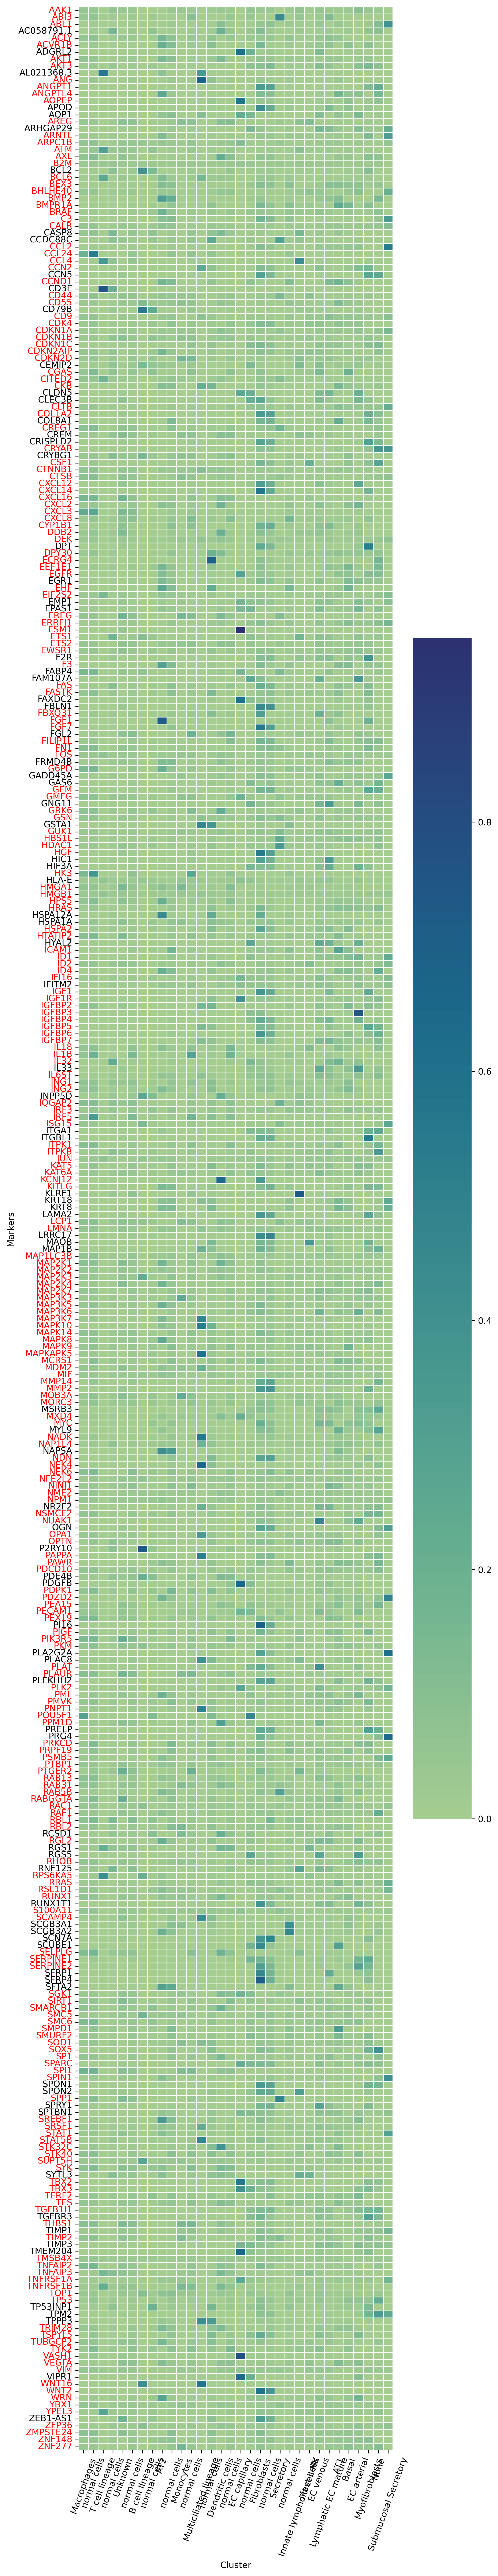

In [6]:
def get_matrix(rows,cols,outputs_dict):
    matrix=np.zeros((len(rows),len(cols)))

    for col_index in range(len(cols)):
        cluster=cols[col_index]
        genes=outputs_dict[cluster]
        for gene in genes:
            row_index=rows.index(gene)
            matrix[row_index][col_index]=1
            
    return matrix

def get_matrix_exp(rows,cols,outputs_dict):
    # cluster_cell_ls
    # gene_cell
    # gene_names
    # heatmap显示表达量
    matrix=np.zeros((len(rows),len(cols)))

    for col_index in range(len(cols)):
        cluster=cols[col_index]
        for gene in rows:
            row_index=rows.index(gene)
            cells=cluster_cell_dict[cluster]
            exp=sum(gene_cell[gene_names.index(gene)][cells])/len(cells)
            matrix[row_index][col_index]=exp
    for i,line in enumerate(matrix):
        matrix[i]=matrix[i]/sum(matrix[i])
    return matrix


def get_matrix_new(rows,cols,outputs_dict):
    results=[]
    cols_names=[]
    for col_index in range(len(cols)):
        cluster=cols[col_index]
        cols_names.append(celltype_names[cluster])
        cols_names.append('normal cells')
        all_cells=cluster_cell_ls[cluster]
        sencells=cluster_cell_dict[cluster]
        nonsencells=list(set(all_cells)-set(sencells))
        
        sencell_col=[]
        nonsencell_col=[]
        
        for gene in rows:
            exp=sum(gene_cell[gene_names.index(gene)][sencells])/len(sencells)
            sencell_col.append(exp)
            exp=sum(gene_cell[gene_names.index(gene)][nonsencells])/len(nonsencells)
            nonsencell_col.append(exp)
    
        results.append(sencell_col)
        results.append(nonsencell_col)
    
    for cluster in range(len(celltype_names)):
        if cluster not in cols:
            normal_cells=cluster_cell_ls[cluster]
            cols_names.append(celltype_names[cluster])
            exp_ls=[]
            for gene in rows:
                exp=sum(gene_cell[gene_names.index(gene)][normal_cells])/len(normal_cells)
                exp_ls.append(exp)
            results.append(exp_ls)
    
    results=np.array(results).T
    for i,line in enumerate(results):
        results[i]=results[i]/sum(results[i])
    return results,cols_names

def change_row_order(rows,cols,outputs_dict):
    # 按表达数量从少到多排序
    matrix=get_matrix(rows,cols,outputs_dict)

    results=[]
    for i,lines in enumerate(matrix):
        results.append([i,sum(lines)])
    results=sorted(results, key=lambda item: item[1])
    indexs=[i[0] for i in results]
    rows=np.array(sorted(list(total_genes)))[indexs]
    rows=list(rows)
    return rows

def change_row_order_by_list(rows,head_list):
    for i in head_list:
        print(i)
        rows.remove(i)
    rows=head_list+rows
    
    return rows



rows=sorted(list(total_genes))
cols=sorted(list(outputs_dict.keys()))

        
# rows=change_row_order(rows,cols,outputs_dict)
# head_list=['ADH1C',
#             'CALHM6',
#            'CLDN3',
#            'GADD45G',
#            'GCNT3',
#            'HMOX1',
#            'IQGAP2',
#            'PTGES',
#            'RHOV',
#            'SAA2',
#            'SBSN',
#            'SERPINB2',
#            'SERPINB4',
#            'SYTL2',
#            'TIMP2',
#            'TNFRSF10C',
#            'VSTM2L',
#            'SLC13A3',

#            'CENPA',
#            'DKK1',
#            'DEPDC1',
#            'HEG1',
#            'MOB3A',
#            'PCDH7',
#           ]

# rows=change_row_order_by_list(rows,head_list)

matrix,cols_names=get_matrix_new(rows,cols,outputs_dict)

plt.figure(figsize=(8,50),dpi=300)

ax=sns.heatmap(matrix, cmap="crest",xticklabels=cols_names,yticklabels=rows,linewidth=.5)
plt.ylabel('Markers')
plt.xlabel("Cluster")
# plt.get_ticklines()
for tick in ax.get_xticklabels():
    tick.set_rotation(70)

indexs=[]
sen_gene_names=[gene_names[i] for i in sen_gene_ls]
for i,j in enumerate(rows):
    if j in sen_gene_names:
        indexs.append(i)
for i in indexs:
    ax.get_yticklabels()[i].set_color("red") 

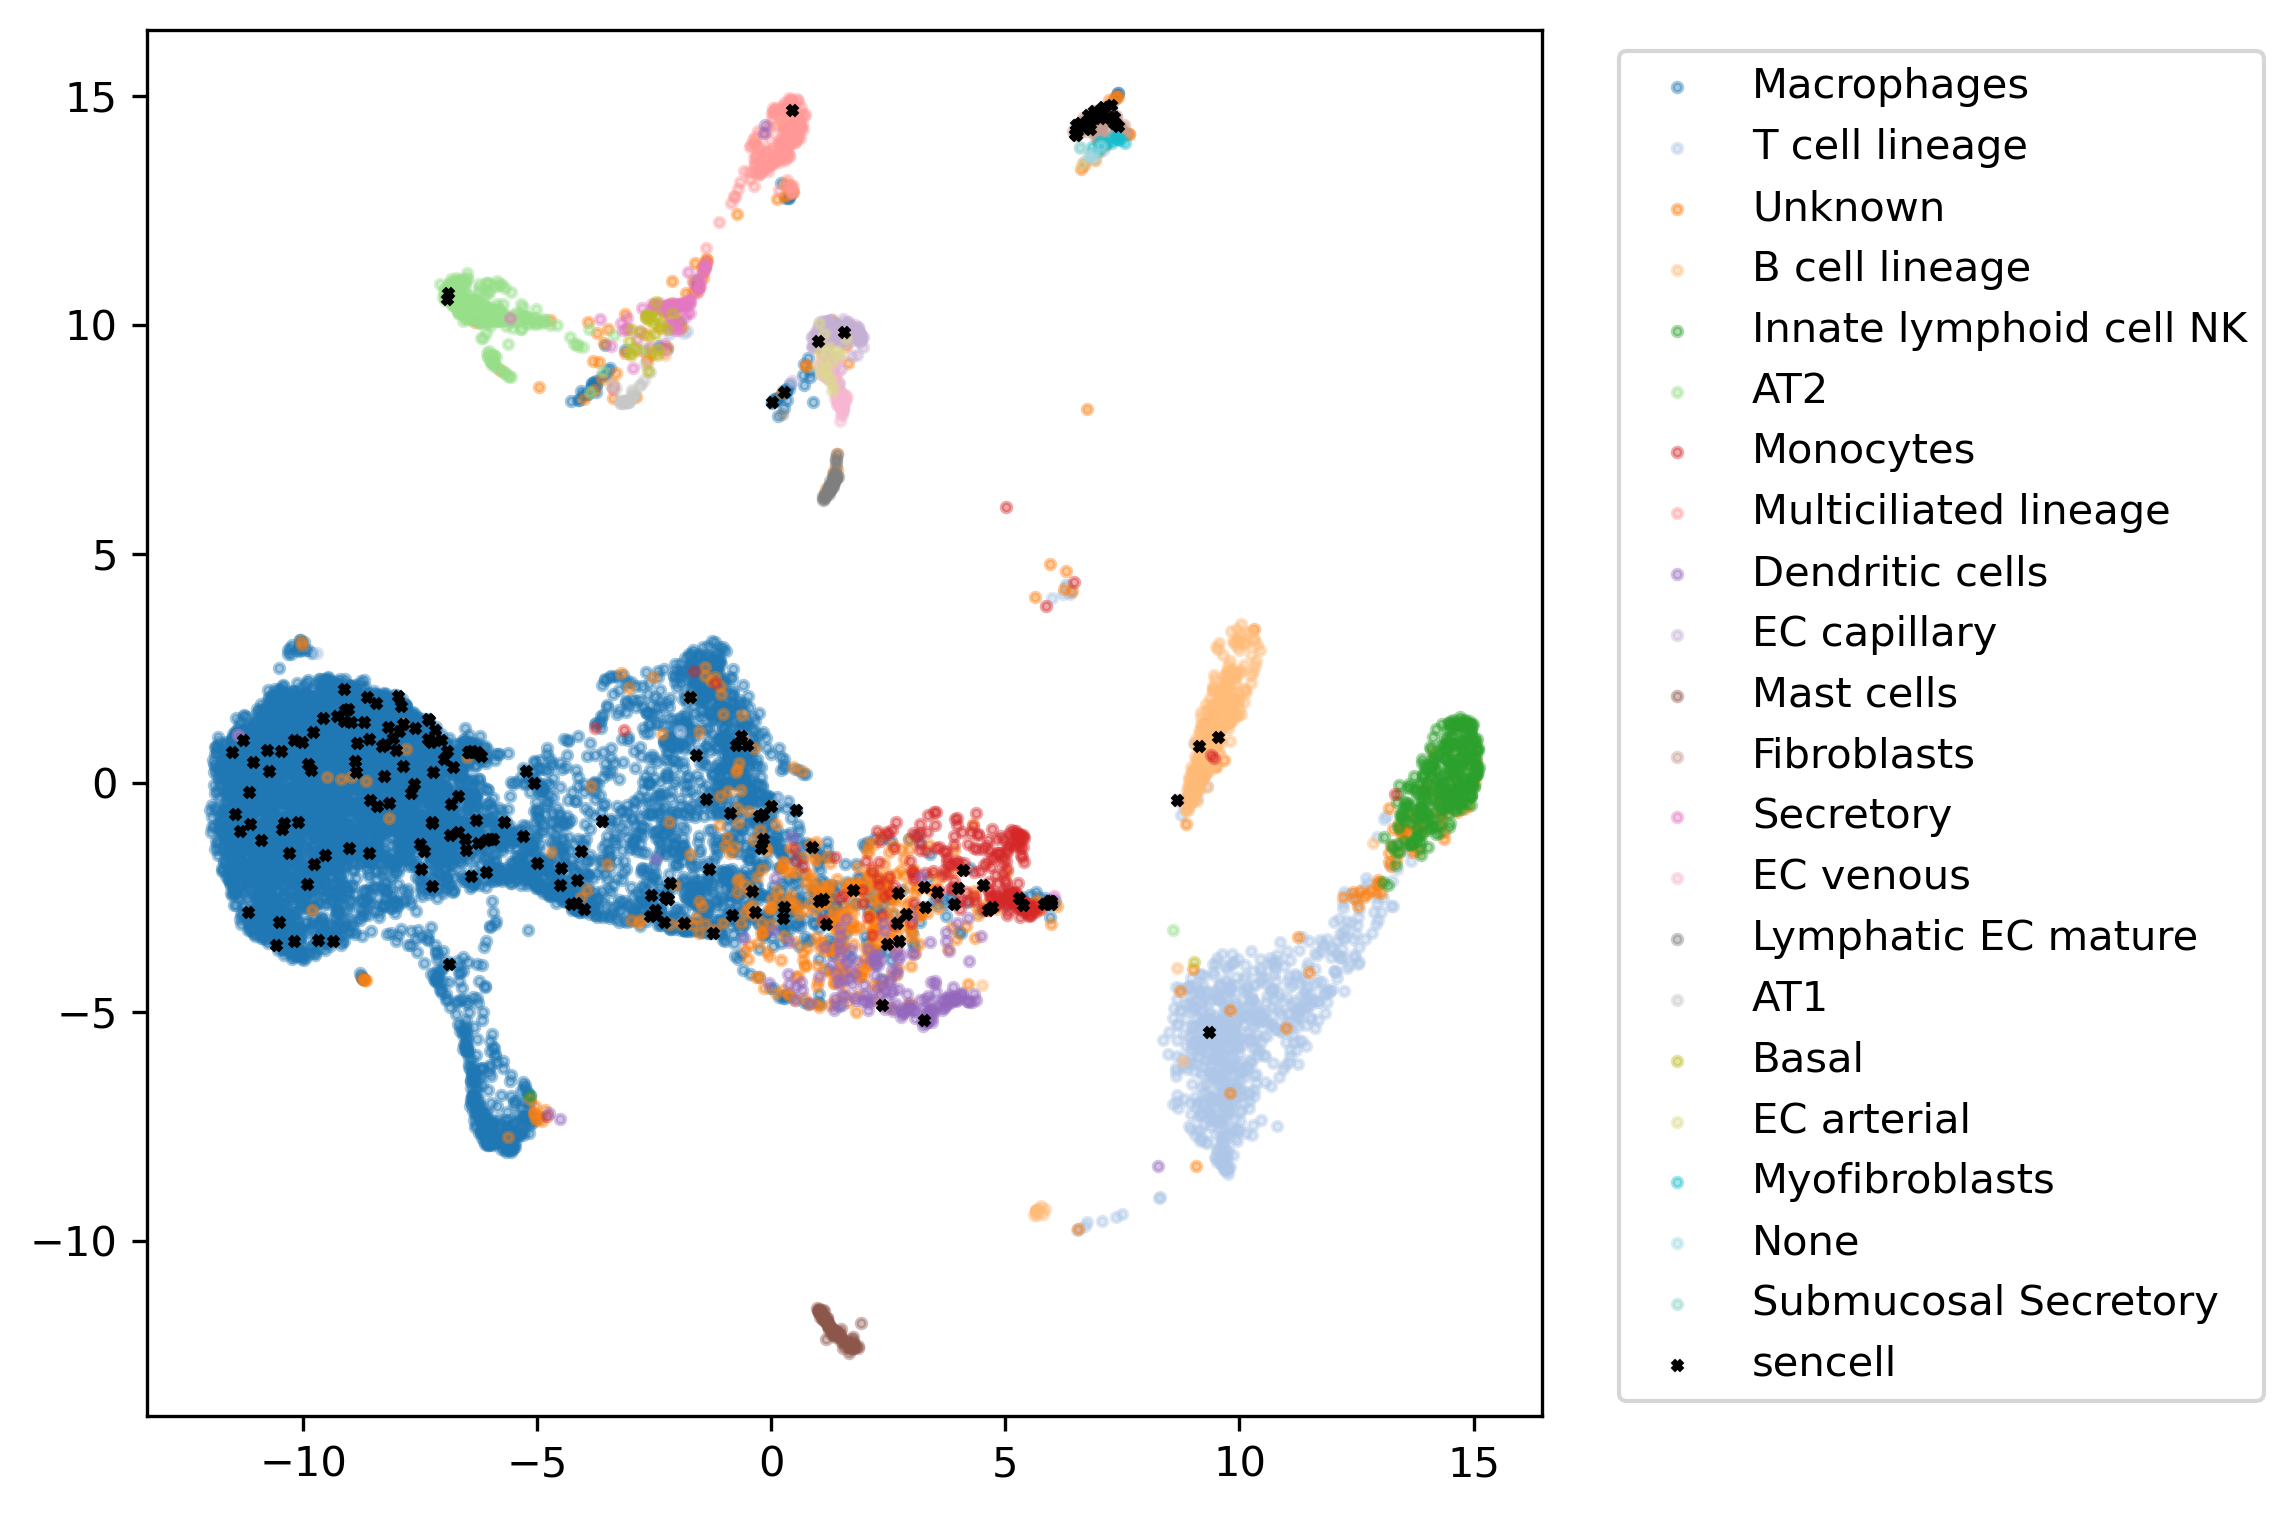

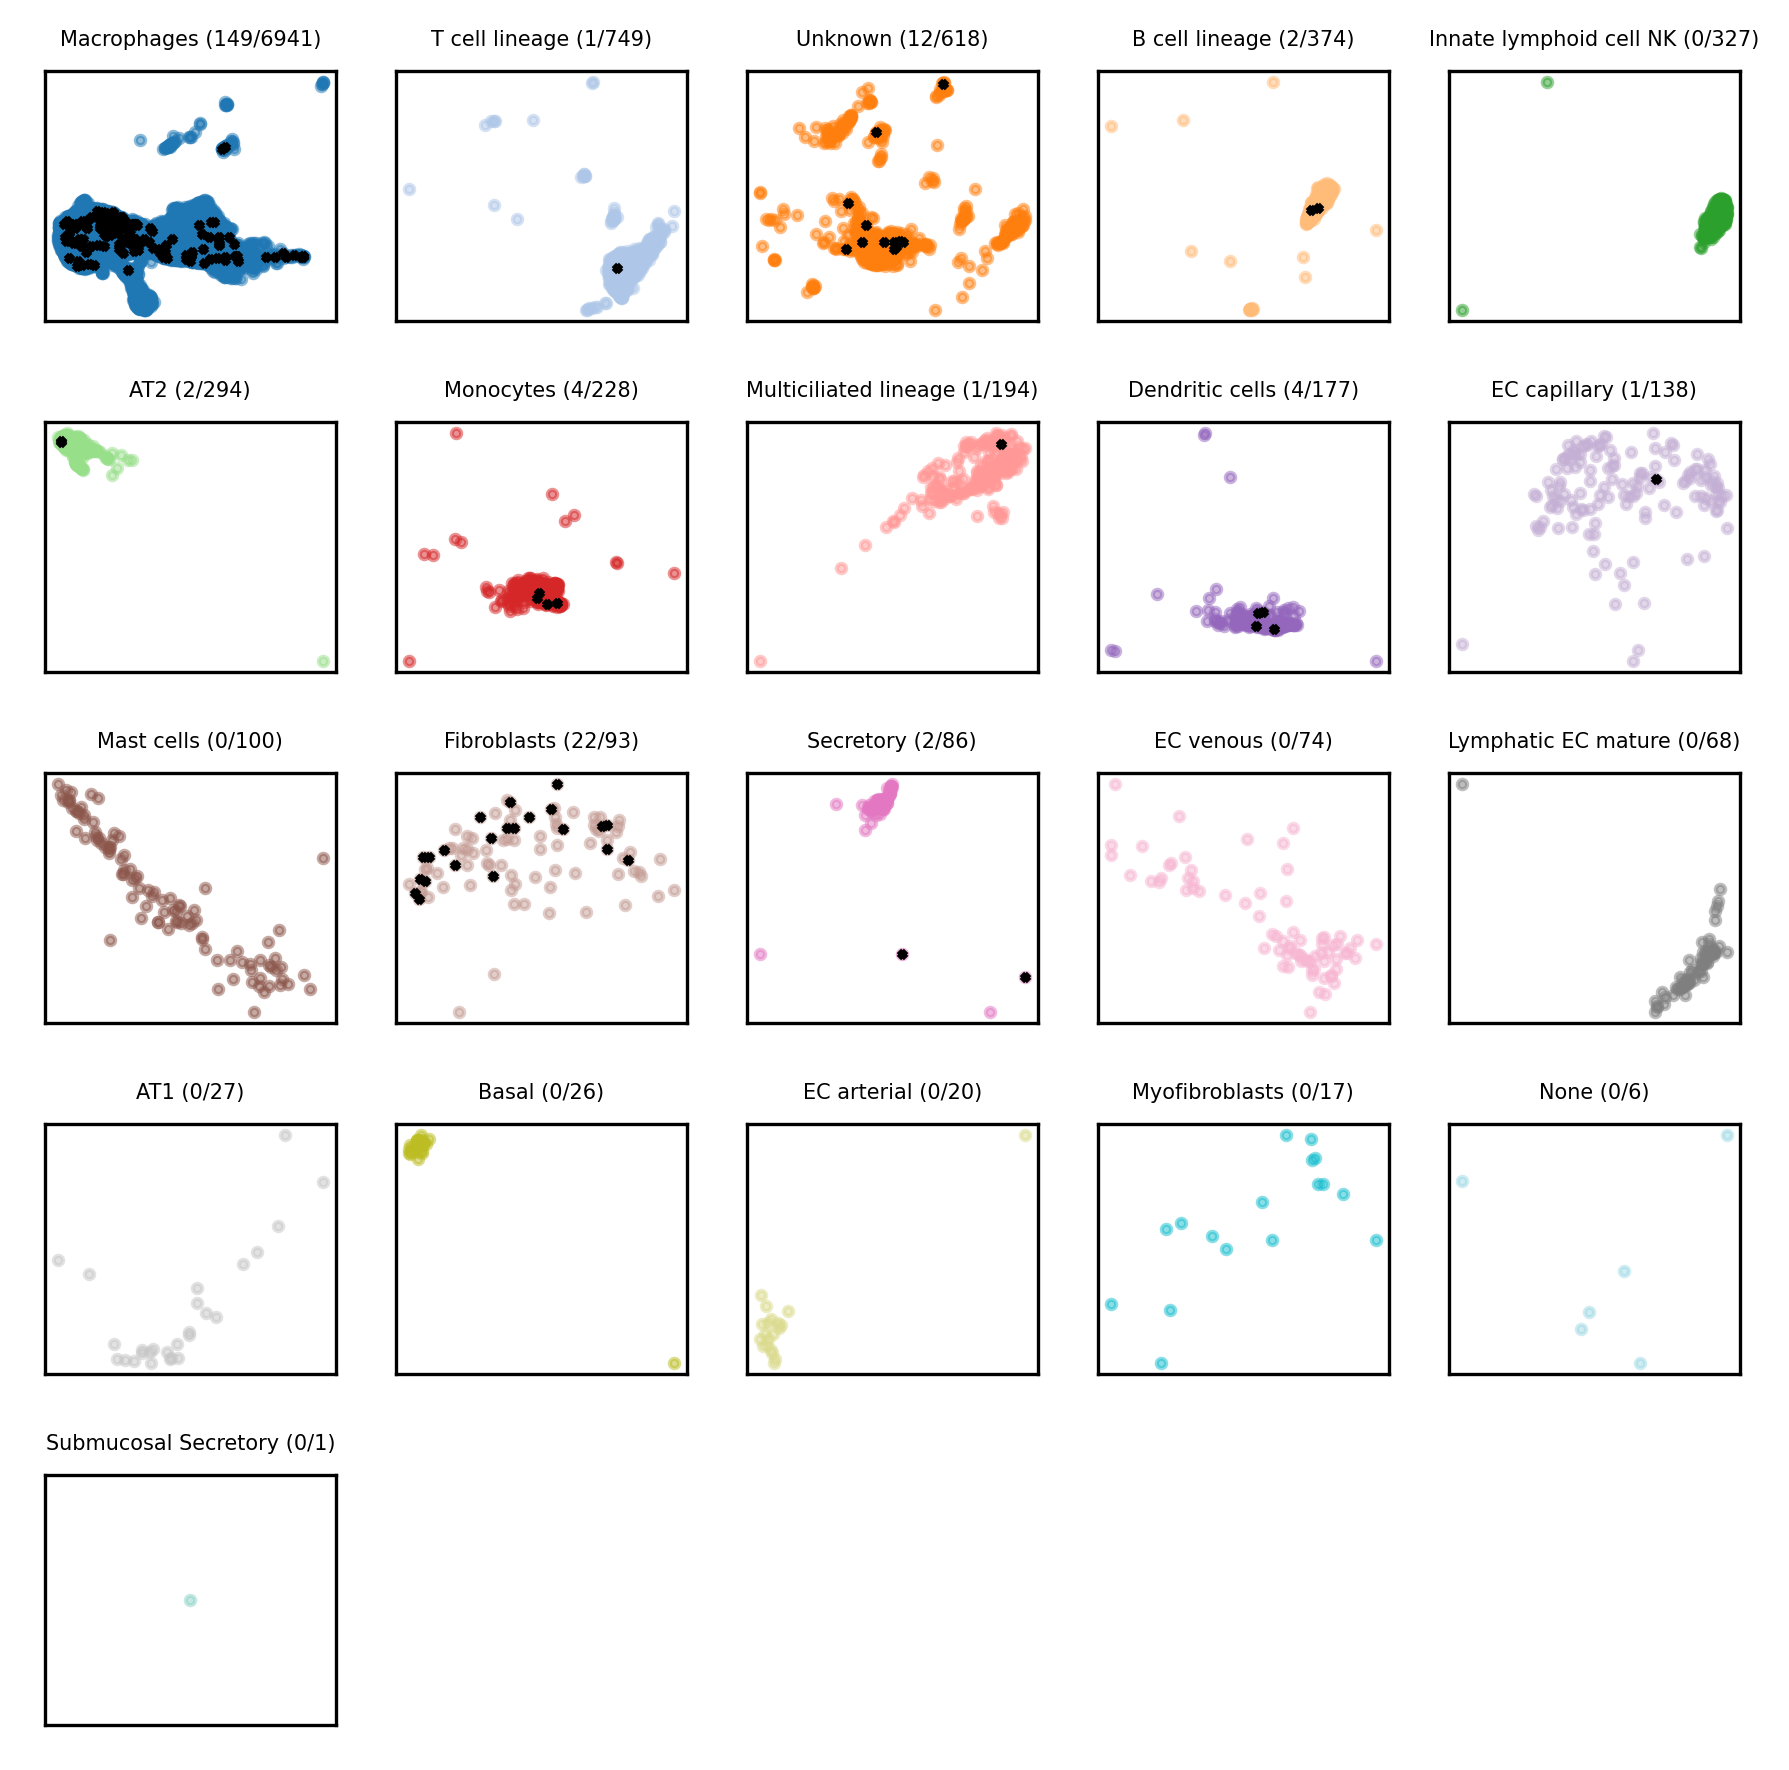

In [9]:
def umapPlot(embedding,cell_index_ls,clusters=None,reduce=False,labels=None):
    # if tensor: embedding should be .cpu().detach()
    # clusters: Nxt
    # t里面存的是行的index
    if reduce:
        reducer = umap.UMAP()
        embedding = reducer.fit_transform(embedding)
    
    plt.figure(figsize=(6,6),dpi=300)
    cmap1 = matplotlib.cm.get_cmap('tab20')        
    cmap2 = matplotlib.cm.get_cmap('Set3')  
    color_ls=cmap1.colors+cmap2.colors
    if clusters is None:
        plt.scatter(embedding[:,0],embedding[:,1],alpha=0.5,s=5)
    else:
        for i,(cluster,label) in enumerate(zip(clusters,labels)):
            plt.scatter(embedding[cluster,0],embedding[cluster,1],alpha=0.4,s=5,color=color_ls[i],label=label)
            
        plt.scatter(embedding[cell_index_ls,0],embedding[cell_index_ls,1],s=5,color='black',marker='x',label='sencell')
        plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

def subUmapPlot(embedding,clusters=None,reduce=False,labels=None):
    # if tensor: embedding should be .cpu().detach()
    # clusters: Nxt
    # t里面存的是行的index
    if reduce:
        reducer = umap.UMAP()
        embedding = reducer.fit_transform(embedding)
    
    fig, axes = plt.subplots(5, 5, sharex=False, sharey=False,figsize=(6,6),dpi=300)

    cmap1 = matplotlib.cm.get_cmap('tab20')        
    cmap2 = matplotlib.cm.get_cmap('Set3')  
    color_ls=cmap1.colors+cmap2.colors
    if clusters is None:
        plt.scatter(embedding[:,0],embedding[:,1],alpha=0.5,s=5)
    else:
        x_s=[]
        y_s=[]
        label_s=[]
        for cluster,label in zip(clusters,labels):
            x_s.append(embedding[cluster,0])
            y_s.append(embedding[cluster,1])
            label_s.append(label)
        count=0
        for i, row in enumerate(axes):
            for j, col in enumerate(row):
                if count<21:
                    col.scatter(x_s[count],y_s[count],alpha=0.5,color=color_ls[count],s=5)
                    sencell_num=0
                    if count in cluster_cell_dict:
                        # 这一簇有老化细胞
                        col.scatter(embedding[cluster_cell_dict[count],0],embedding[cluster_cell_dict[count],1],
                                   s=3,color='black',marker='x',label='sencell')
                        sencell_num=len(cluster_cell_dict[count])
                        
                    col.set_title(f"{label_s[count]} ({sencell_num}/{len(clusters[count])})",fontsize=5)
                    count+=1
                else:
                    col.set_visible(False)
    plt.setp(fig.axes, yticks=[],xticks=[])
    
    plt.tight_layout()

        
umapPlot(adata.obsm['X_umap'],np.array(cell_index_ls),clusters=cluster_cell_ls,labels=celltype_names)
subUmapPlot(adata.obsm['X_umap'],clusters=cluster_cell_ls,labels=celltype_names)